In [1]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir('/content/drive/My Drive/kds/1sem/ditw/ditw_project')

In [3]:
!pip install sentence_transformers
!pip install hdbscan
!pip install umap-learn
!pip install matplotlib
!pip install pandas

     |████████████████████████████████| 78 kB 3.6 MB/s 
     |████████████████████████████████| 3.1 MB 16.1 MB/s 
     |████████████████████████████████| 3.3 MB 35.2 MB/s 
     |████████████████████████████████| 1.2 MB 38.6 MB/s 
     |████████████████████████████████| 59 kB 7.2 MB/s 
     |████████████████████████████████| 895 kB 39.2 MB/s 
     |████████████████████████████████| 596 kB 39.8 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.1.0-py3-none-any.whl size=121000 sha256=97b1289592876500150327f16b7574b2d5a7c21a6c5f373cb853baab9e264d59
  Stored in directory: /root/.cache/pip/wheels/90/f0/bb/ed1add84da70092ea526466eadc2bfb197c4bcb8d4fa5f7bad
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 6.4 MB 4.8 MB/s 
  Installing build dependencies ... done
  Getting requirements

In [4]:
from src.json_utils import read_json, read_jsonl
from sentence_transformers import SentenceTransformer
import hdbscan
import umap
import matplotlib.pyplot as plt
import pandas as pd
from src.preprocessing import *
from sklearn.cluster import DBSCAN

In [12]:
data = read_jsonl('data/dkpol_tweets.jsonl')
df = pd.DataFrame(data)
df[df['in_reply_to_user_id'].isna()]
df.created_at = pd.to_datetime(df.created_at)
sub = df[['created_at', 'text', 'entities']].groupby(df.created_at.dt.to_period("M")).head(350)
#sub = df.groupby(df.created_at.dt.to_period("M")).head(100)
df = sub
text = df['text']

Reading data/dkpol_tweets.jsonl


/usr/local/lib/python3.7/dist-packages/pandas/core/arrays/datetimes.py:1092: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


In [13]:
len(df)

6650

In [14]:
import matplotlib.pyplot as plt
from collections import Counter

entities = list(df['entities'].values)
hashtags = list()
for e in entities:
    try:
        for tag in e['hashtags']:
            hashtags.append(tag['tag'])
    except:
        continue

Counter(hashtags).most_common(10)

[('dkpol', 6473),
 ('dkmedier', 1062),
 ('dkgreen', 401),
 ('dkbiz', 193),
 ('svpol', 151),
 ('sundpol', 150),
 ('eudk', 131),
 ('eupol', 102),
 ('DKpol', 100),
 ('COVID19dk', 94)]

In [15]:
# for i in subset.head(20).iterrows():
#     print(i[1]['text'])
#     if 'urls' in i[1]['entities']:
#         print(i[1]['entities']['hashtags'])
#     print()

In [68]:
text = replace_url(df['text'], replacement = 'URL')
#text = df['text']
# for i in text[:50]:
#     print(i)
#     print()

In [17]:
#encoder = SentenceTransformer('Maltehb/-l-ctra-danish-electra-small-cased')
encoder = SentenceTransformer('Maltehb/-l-ctra-danish-electra-small-cased')
embeddings = encoder.encode(text, show_progress_bar=True, normalize_embeddings=True)

Some weights of the model checkpoint at /root/.cache/torch/sentence_transformers/Maltehb_-l-ctra-danish-electra-small-cased were not used when initializing ElectraModel: ['generator.encoder.layer.4.attention.self.key.bias', 'generator_predictions.decoder.weight', 'generator.encoder.layer.5.output.LayerNorm.weight', 'discriminator_predictions.dense.weight', 'generator.encoder.layer.9.attention.output.LayerNorm.bias', 'generator.encoder.layer.8.output.dense.bias', 'generator_predictions.LayerNorm.weight', 'generator.encoder.layer.7.output.dense.weight', 'generator.encoder.layer.2.intermediate.dense.weight', 'generator.encoder.layer.10.attention.self.value.weight', 'generator.encoder.layer.9.intermediate.dense.bias', 'generator.encoder.layer.2.attention.output.dense.bias', 'generator.encoder.layer.4.attention.output.dense.weight', 'generator.encoder.layer.3.attention.output.LayerNorm.bias', 'generator.encoder.layer.11.intermediate.dense.bias', 'generator.encoder.layer.7.intermediate.dense

Batches:   0%|          | 0/208 [00:00<?, ?it/s]

In [18]:
text[:2]

['Det er på tide køreprøver kommer i konkurrence og på private hænder. Ligesom med bilsyn. Væk med ventetider og styrket kvaliteten. #dkpol  [URL]',
 'Min klumme i @berlingske  "I utallige år, især op til valgkampe, har der været fokus på jobcentrene og beskæftigelsesindsatsen. Guld og grønne skove er lovet, men alt er lige så gudsforladt og dysfunktionelt som altid." #dkpol #dkmedier \n\n[URL]']

In [142]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import TweetTokenizer
tweet_tokenizer = TweetTokenizer().tokenize
vectorizer = TfidfVectorizer(tokenizer = tweet_tokenizer, stop_words = stopwords, ngram_range = (1,3), max_features = 1000, min_df=2, max_df = 0.95)
X = vectorizer.fit_transform(text)
#vectorizer.vocabulary_

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['.', 'a', 'bl', 'ca', 'f.eks', 'pga'] not in stop_words.
  % sorted(inconsistent)


In [143]:
umap_embeddings = umap.UMAP(n_neighbors=15, 
                            n_components=5, 
                            metric='cosine').fit_transform(X)

In [144]:
cluster = hdbscan.HDBSCAN(min_cluster_size=10,
                          metric='euclidean',                      
                          cluster_selection_method='eom',
                          cluster_selection_epsilon=0.5).fit(X)

In [145]:
print(Counter(cluster.labels_))

Counter({1: 1936, 11: 1154, -1: 998, 7: 453, 15: 296, 42: 127, 9: 114, 4: 89, 61: 88, 13: 86, 54: 66, 33: 64, 25: 56, 29: 50, 45: 43, 0: 40, 41: 37, 56: 36, 60: 34, 18: 33, 38: 31, 59: 30, 35: 30, 36: 29, 2: 27, 23: 26, 27: 26, 6: 26, 3: 26, 58: 25, 19: 25, 30: 24, 10: 23, 17: 23, 8: 23, 5: 23, 16: 22, 44: 22, 55: 22, 46: 21, 26: 21, 49: 21, 28: 19, 32: 19, 14: 19, 52: 18, 50: 17, 12: 17, 34: 16, 57: 15, 48: 15, 37: 15, 53: 15, 20: 14, 21: 14, 40: 14, 22: 13, 24: 13, 47: 11, 43: 10, 39: 10, 51: 10, 31: 10})


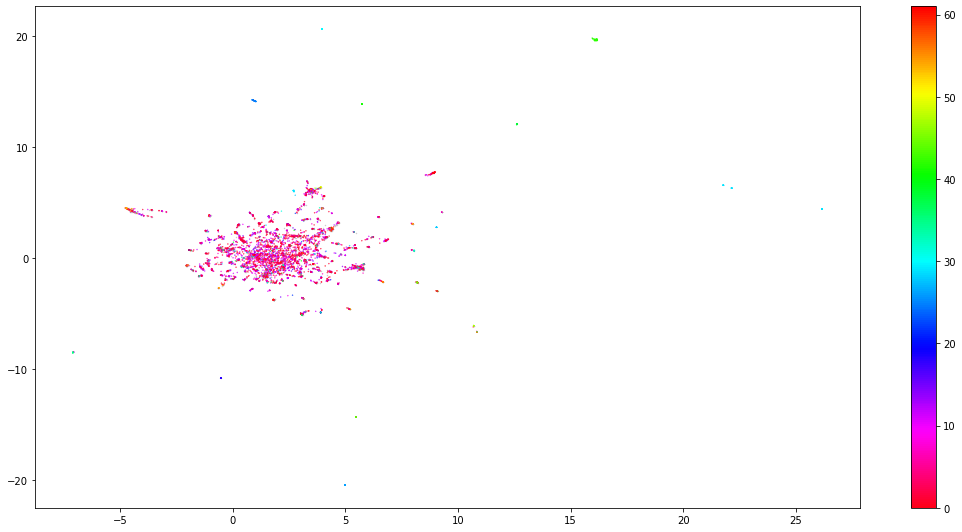

In [146]:
# Prepare data
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(X)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(15, 7.5))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.15)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.15, cmap='hsv_r')
plt.colorbar()
plt.tight_layout()

In [150]:
docs_df = pd.DataFrame(text, columns=["Doc"])
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

In [151]:
with open('data/danish_stopwords.txt') as stop_file:
  stopwords = [word.strip() for word in stop_file.readlines()]
stopwords[:5]

['ad', 'af', 'aldrig', 'alene', 'alle']

In [152]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

def c_tf_idf(documents, m, ngram_range=(2, 3)):
    count = CountVectorizer(tokenizer = tweet_tokenizer, stop_words = stopwords, ngram_range = (1,3), max_features = 1000, min_df=2, max_df = 0.95).fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count
  
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(data))

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"
/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['.', 'a', 'bl', 'ca', 'f.eks', 'pga'] not in stop_words.
  % sorted(inconsistent)


In [153]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Topic,Size
2,1,1936
12,11,1154
0,-1,998
8,7,453
16,15,296
43,42,127
10,9,114
5,4,89
62,61,88
14,13,86


In [157]:
len(top_n_words)
top_n_words[15]

[('.', 0.24362721116732397),
 (',', 0.2313714970174009),
 ('. #dkpol', 0.08255465143051167),
 ('?', 0.08221003161668788),
 ('#dkpol url', 0.0748224944776052),
 ('-', 0.06976834885225473),
 ('#dkmedier', 0.05792952743469218),
 ('"', 0.05474754960997255),
 ('!', 0.05400480846162833),
 (':', 0.051756225609728104),
 ('#dkpol #dkmedier', 0.041341673484269134),
 ('...', 0.03696751640303635),
 ('(', 0.035596124914538424),
 ('danmark', 0.03456899985415141),
 ('/', 0.03212844988227351),
 ('..', 0.03203658357019187),
 ('? #dkpol', 0.03176364724139811),
 ('mennesker', 0.030321986252209658),
 ('. #dkpol url', 0.02750509136265444),
 (')', 0.027356098217806084)]

In [158]:
from sklearn.metrics.pairwise import cosine_similarity

for i in range(8):
    # Calculate cosine similarity
    similarities = cosine_similarity(tf_idf.T)
    np.fill_diagonal(similarities, 0)

    # Extract label to merge into and from where
    topic_sizes = docs_df.groupby(['Topic']).count().sort_values("Doc", ascending=False).reset_index()
    topic_to_merge = topic_sizes.iloc[-1].Topic
    topic_to_merge_into = np.argmax(similarities[topic_to_merge + 1]) - 1

    # Adjust topics
    docs_df.loc[docs_df.Topic == topic_to_merge, "Topic"] = topic_to_merge_into
    old_topics = docs_df.sort_values("Topic").Topic.unique()
    map_topics = {old_topic: index - 1 for index, old_topic in enumerate(old_topics)}
    docs_df.Topic = docs_df.Topic.map(map_topics)
    docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

    # Calculate new topic words
    m = len(data)
    tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m)
    top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"
/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['.', 'a', 'bl', 'ca', 'f.eks', 'pga'] not in stop_words.
  % sorted(inconsistent)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be us

In [159]:
# Get topic ids of alle clusters with more than 200 documents
topic_subset = topic_sizes[topic_sizes.Doc > 100]
topic_subset = list(topic_subset.Topic.values)

In [167]:
print(topic_subset)
len(top_n_words)
#topic_sizes.head()
top_n_words[9]

[1, 11, -1, 7, 15, 38, 9]


[('.', 0.25717959439327687),
 (',', 0.2218179100264018),
 ('#dkpol url', 0.09756885813453293),
 ('-', 0.07887212392989093),
 ('#dkmedier', 0.07140672552024863),
 (':', 0.05283413364139572),
 ('…', 0.0525754151988801),
 ('. #dkpol', 0.05223231488566299),
 ('#kv21', 0.05194033173969952),
 ('?', 0.050837480454984554),
 ('by', 0.04726041829255811),
 ('url url', 0.046685369328370356),
 ('"', 0.043344765970276984),
 ('kvinder', 0.04239658866331123),
 ('!', 0.04134716018110307),
 ('danmark', 0.040275438689790555),
 ('#dkbiz', 0.03980785718985224),
 ('👇', 0.03897002678900282),
 ('url #dkpol', 0.03619952378174527),
 ('#dkmedier #dkpol', 0.035870323168517626)]

In [168]:
cluster_embeddings = {cluster_id: {} for cluster_id in set(cluster.labels_)}
for idx, clu in enumerate(cluster.labels_):
  if clu == -1:
    continue
  cluster_embeddings[clu][idx]=embeddings[idx, :].tolist()

In [169]:
avg_embeddings = {}
for idx, embs in cluster_embeddings.items():
  #avg_embeddings[idx] = np.mean(np.array(embs), axis = 0)
  v = np.mean(np.array([val for val in embs.values()]), axis = 0)
  normalized_v = v / np.sqrt(np.sum(v**2))
  avg_embeddings[idx] = normalized_v

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [171]:
len(avg_embeddings)

63

In [1]:
from sentence_transformers.util import semantic_search
import torch

for cluster_id in topic_subset:
  avg_emb = torch.tensor(avg_embeddings[cluster_id])
  documents = torch.tensor(np.array([val for val in cluster_embeddings[cluster_id].values()]))
  print(avg_emb.size(), docuements.size())
  print(documents.size())
  exit()
  top_similar = semantic_search(avg_emb, documents, top_k = 5)
  print(top_similar)

NameError: ignored

In [ ]:
for i in text[:40]:
  print(i)
  print(tweet_tokenizer(i))
  print('------------------------')